In [1]:
import maboss
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [2]:
def to_bits(state, nodes):
    if state == "<nil>":
        return tuple([0]*len(nodes))
    bits = []
    state_list = state.split(" -- ")
    for node in nodes:
        bits.append(1 if node in state_list else 0)
    return tuple(bits)
def to_istates(table, nodes):
    istates = {}
    for index, value in table.iloc[-1, :].items():
        istates.update({to_bits(index, nodes): value})
    return istates

def change_input(istates, name, value):
    new_istates = {}
    for bits, proba in istates.items():
        new_bits = list(bits)
        new_bits[nodes.index(name)] = value
        new_tuples = tuple(new_bits)
        if new_tuples not in new_istates.keys():
            new_istates[new_tuples] = proba
        else:
            new_istates[new_tuples] += proba   
    return new_istates

In [3]:
# Set up the required files
path = "../config/simple_tnf/boolean_network/"
bnd_file = os.path.join(path, "cellfate.bnd")
cfg_WT = os.path.join(path, "cellfate.cfg")

In [4]:
param = {'max_time': 105, 'time_tick': 1, 'sample_count': 100000}
outputs = ['NonACD', 'Apoptosis', 'Survival']

In [5]:
b_sim = maboss.load(bnd_file, cfg_WT)

OrderedDict([('High_NFkB', '0'), ('Low_CASP8', '0'), ('Low_RIP1', '0'), ('Low_cIAP', '0'), ('TransRate', '1/24')])


# Here, no TNF treatment

In [6]:
b_sim.param.update(param)
b_sim.network.set_istate('TNF', [1, 0])
b_sim.network.set_output(outputs)

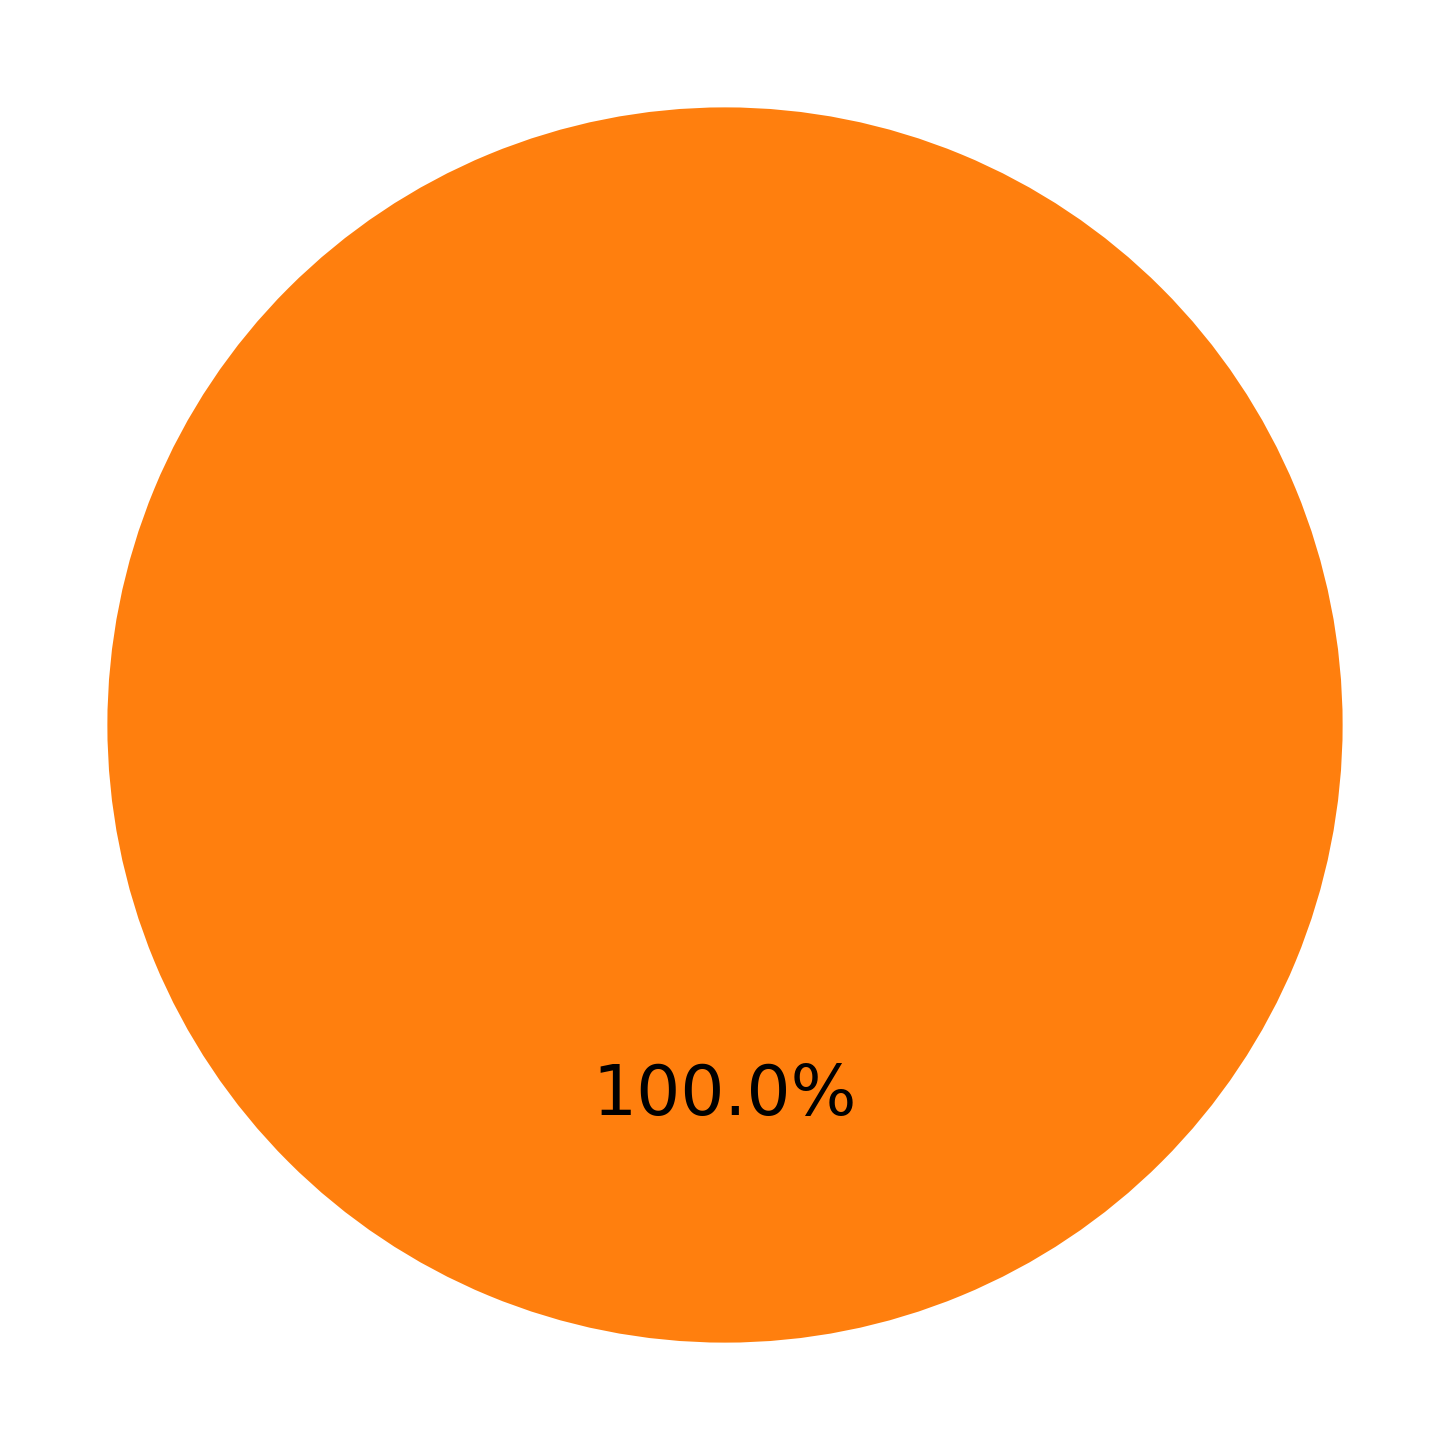

In [7]:
b_res = b_sim.run()
fig = plt.figure(figsize=(3,3), dpi=500, tight_layout=True)
fig.subplots(1)
b_res.plot_piechart(axes=fig.axes[0])
fig.axes[0].get_legend().remove()

# Same one with TNF treatment

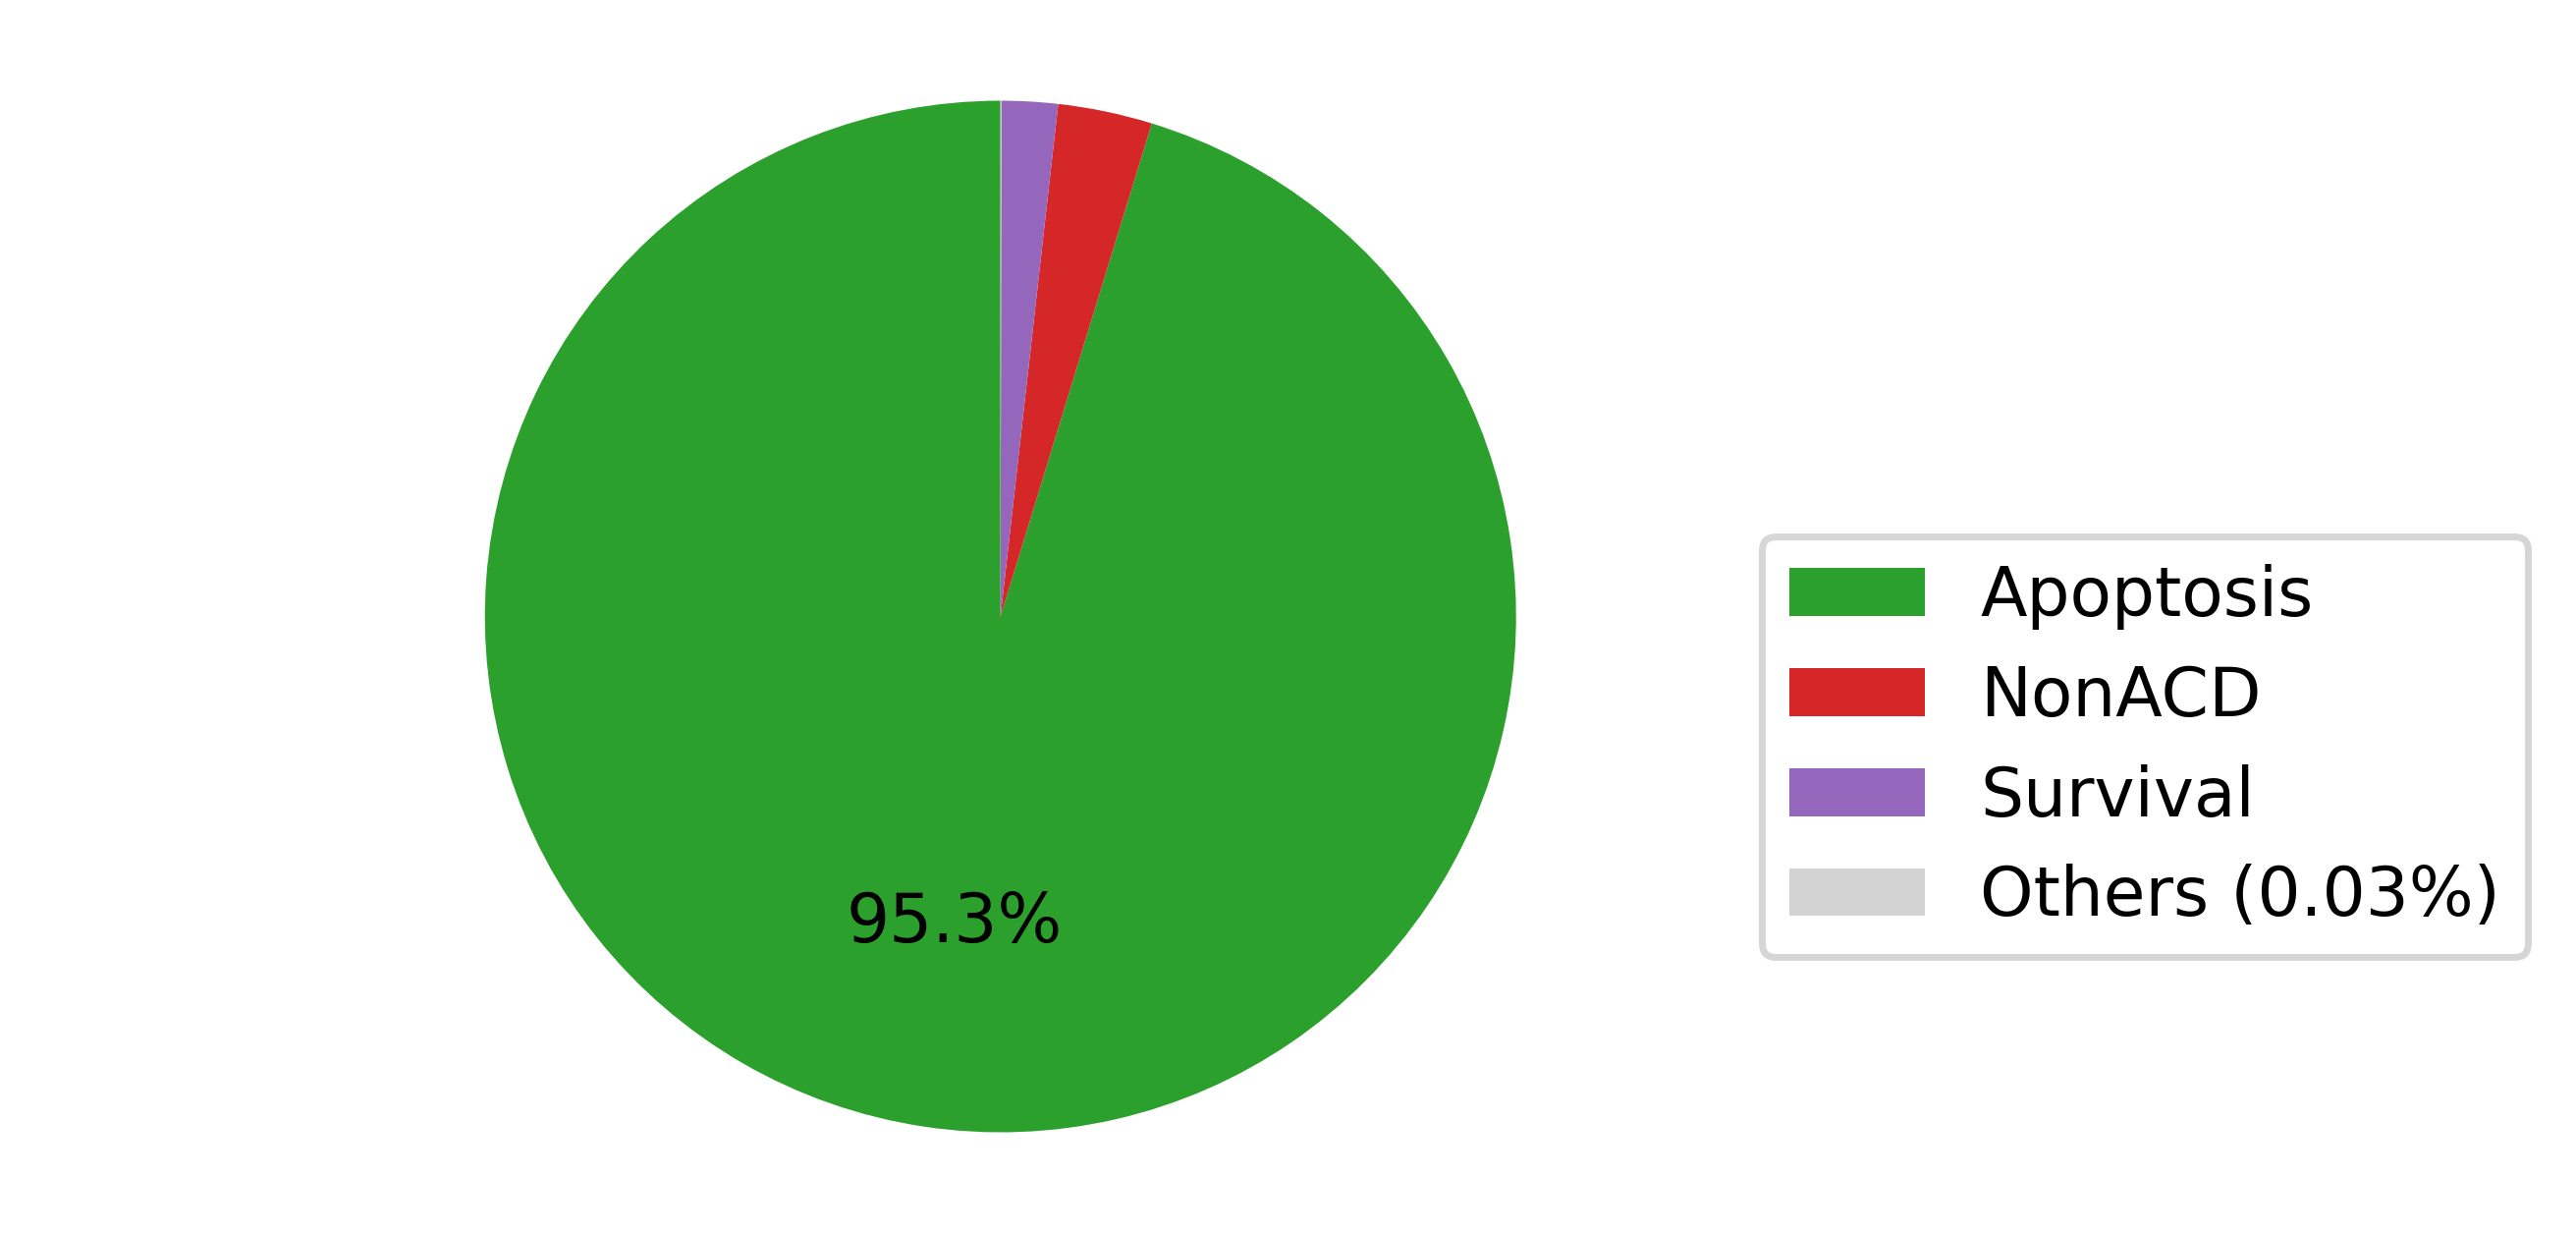

In [8]:
b_sim_tnf = b_sim.copy()
b_sim_tnf.network.set_istate('TNF', [0, 1])
# b_sim_tnf.network.set_istate('mROS', [0, 1])
b_res_tnf = b_sim_tnf.run()
fig = plt.figure(figsize=(5,3), dpi=500)
fig.subplots(1)
b_res_tnf.plot_piechart(axes=fig.axes[0])

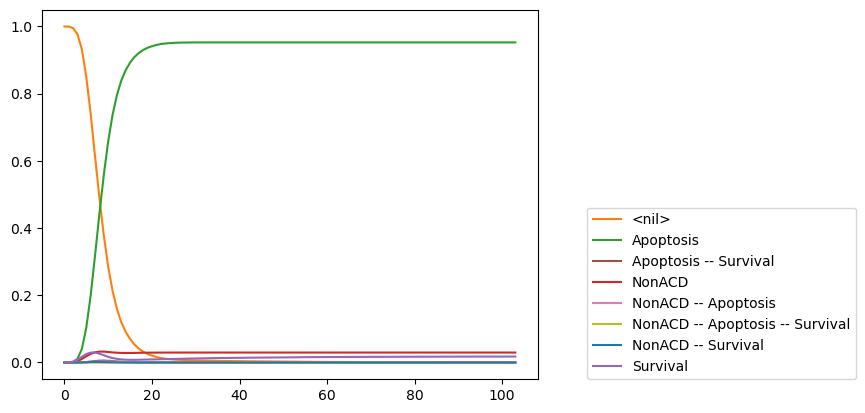

In [9]:
b_res_tnf.plot_trajectory(prob_cutoff=0)

# Here we create a palette of colors to keep the same colors with all figures

In [10]:
palette = ['C1', 'C2', 'C5', 'C3', 'C6', 'C8', 'C0', 'C4']

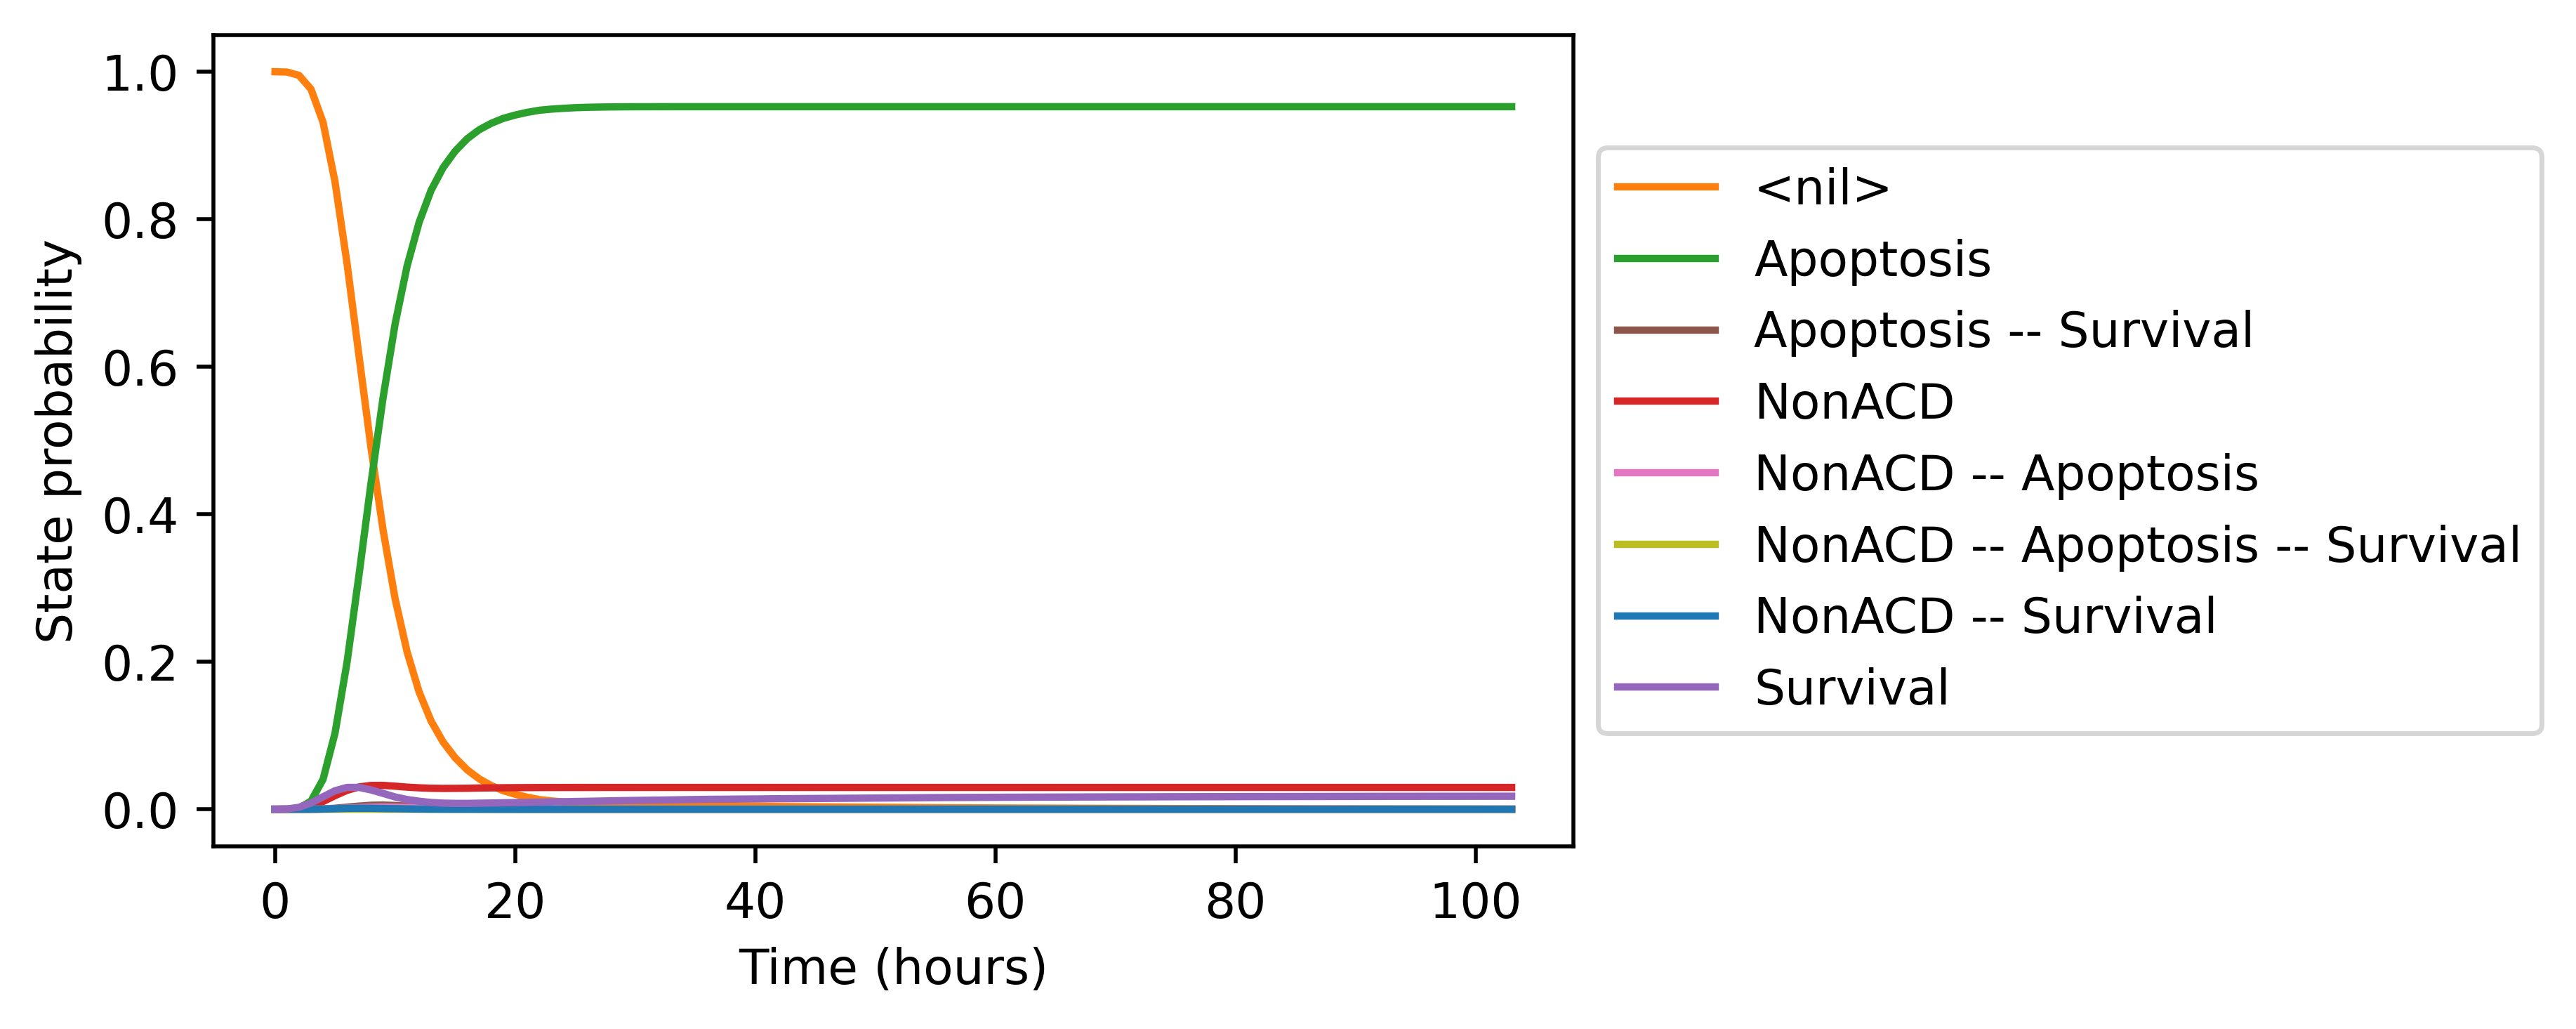

In [11]:
fig = plt.figure(figsize=(5,3), dpi=500)
fig.subplots(1)
b_res_tnf.get_states_probtraj().plot(ax=fig.axes[0], color=palette)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Time (hours)')
plt.ylabel('State probability');


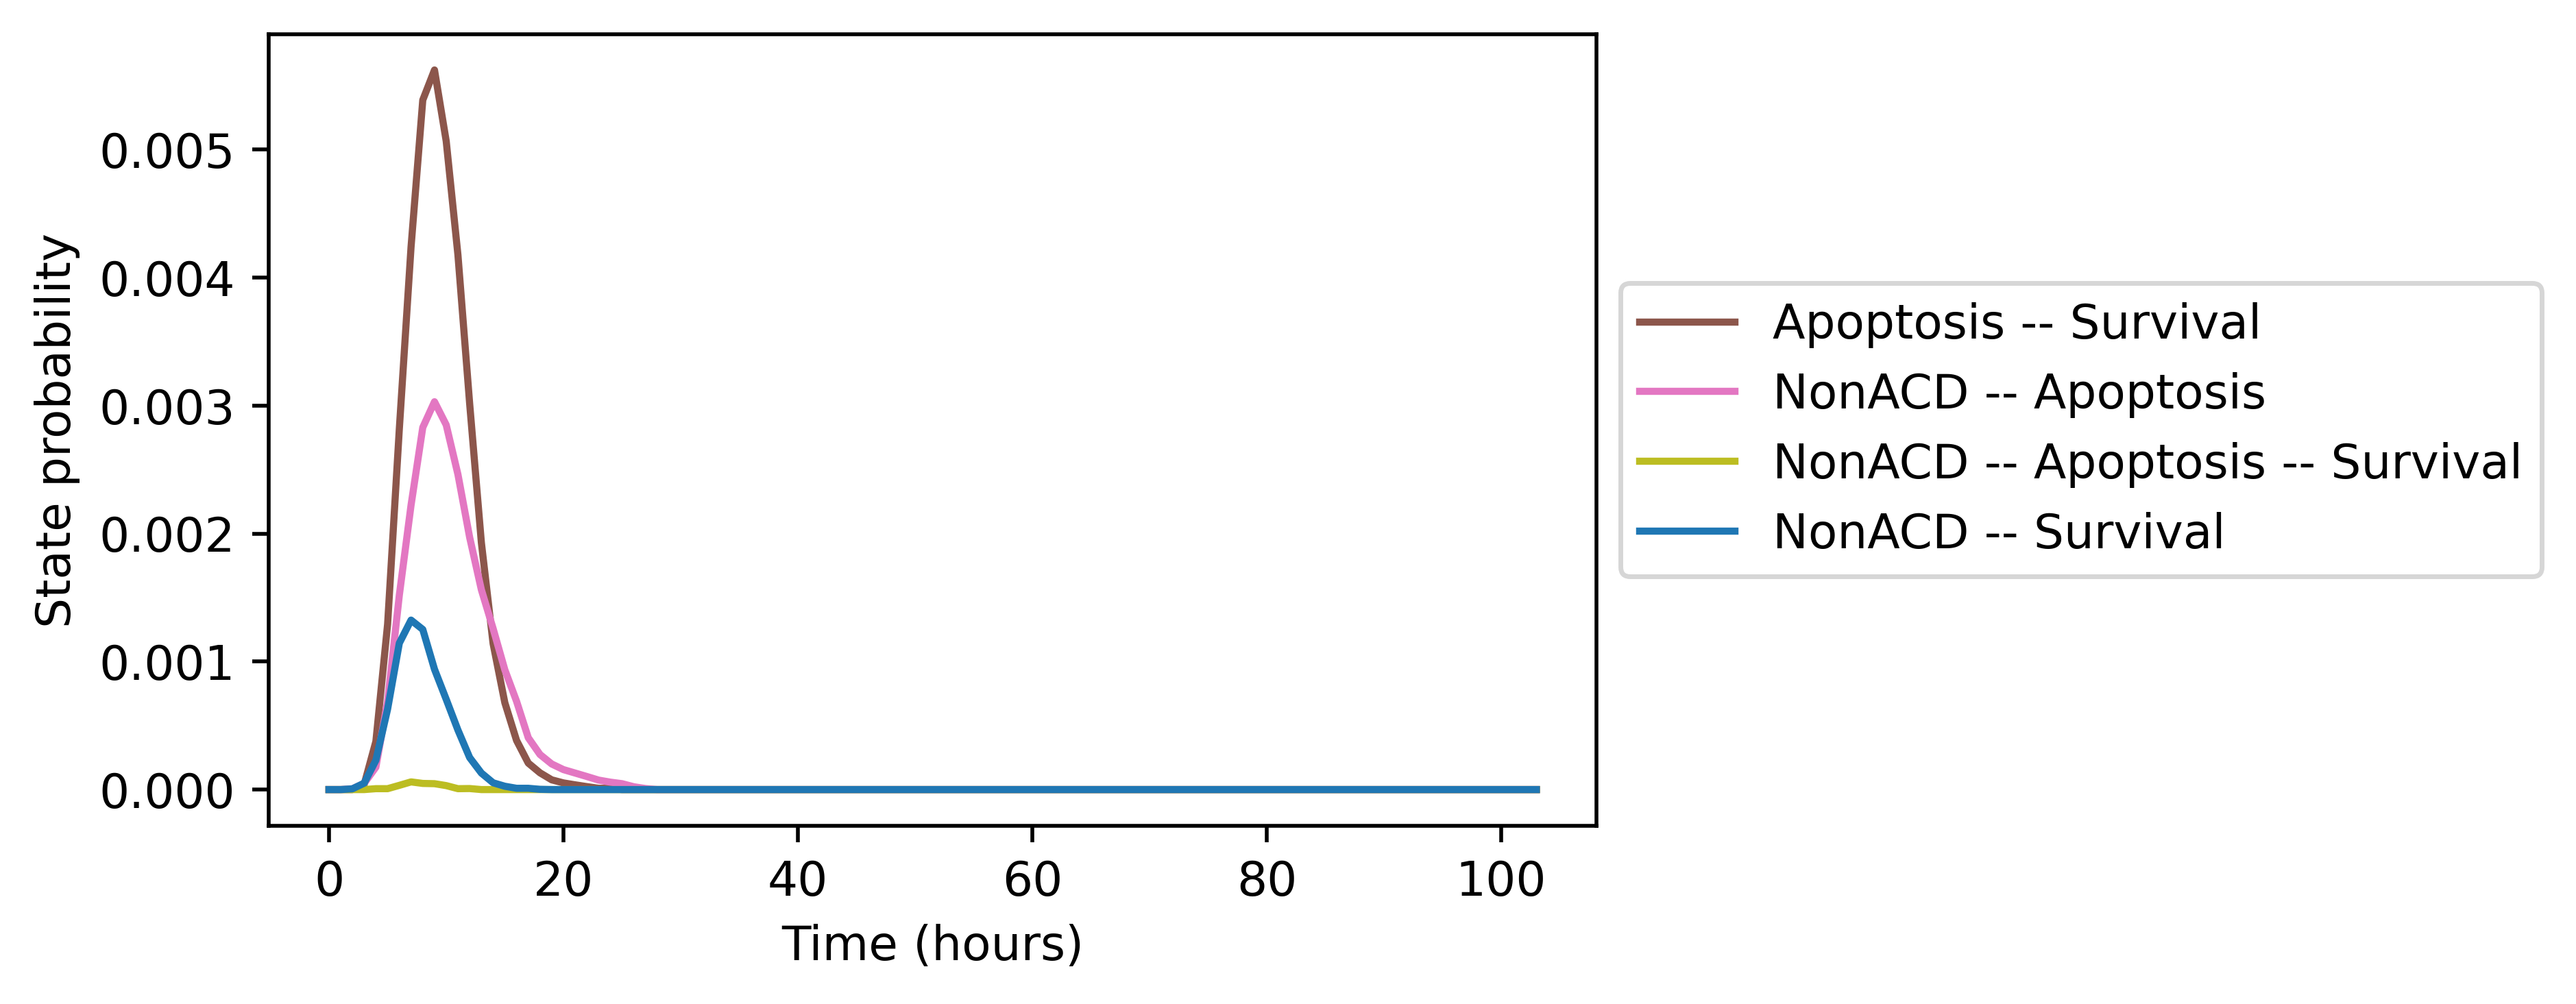

In [12]:
fig = plt.figure(figsize=(5,3), dpi=500)
fig.subplots(1)
b_res_tnf.get_states_probtraj().loc[:, ["Apoptosis -- Survival", "NonACD -- Apoptosis", "NonACD -- Apoptosis -- Survival", "NonACD -- Survival"]].plot(ax=fig.axes[0], color=['C5', 'C6', 'C8', 'C0',])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Time (hours)')
plt.ylabel('State probability');

# Now we do multiple simulations to have pulsed TNF treatments\

For this we need two simulations : 
- One with all nodes as outputs, to be able to completely specify the next simulation's initial condition
- One with only the output we want, to be able to generate the figure (the *_fig simulations)

In [13]:
dur_tnf = 21
dur_no_tnf = 21

In [14]:
nodes = list(b_sim_tnf.network.keys())

# First, with TNF

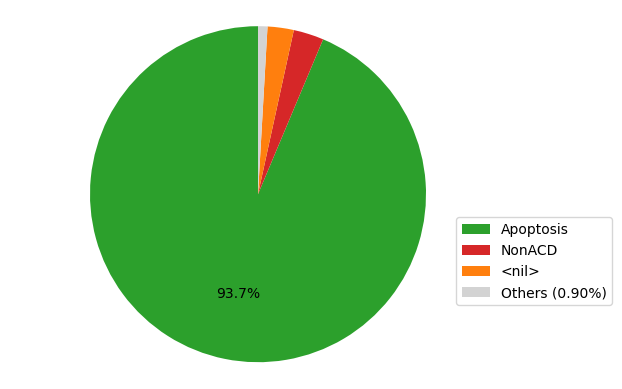

In [15]:
sim_short = b_sim_tnf.copy()
sim_short.update_parameters(max_time=dur_tnf)
sim_short_fig = sim_short.copy()
res_short_fig = sim_short_fig.run()
res_short_fig.plot_piechart()

In [16]:
sim_short.network.set_output(list(sim_short.network.keys()))
res_short = sim_short.run()

# Second, no TNF

First we have to generate our new initial states based on the last time point of the previous simulation

In [17]:
new_istates = change_input(to_istates(res_short.get_states_probtraj(), nodes), "TNF", 0)

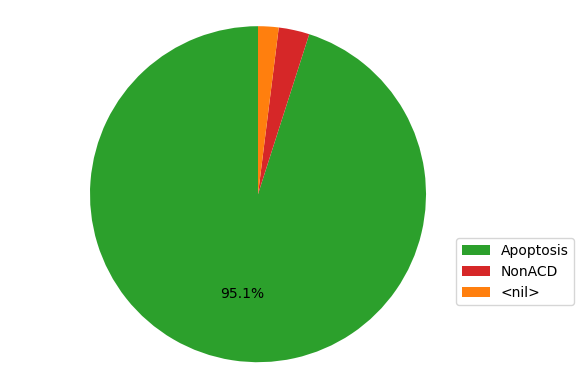

In [18]:
sim_next = sim_short.copy()
sim_next.update_parameters(max_time=dur_no_tnf)
sim_next.network.set_istate(nodes, new_istates)
res_next = sim_next.run()

sim_next_fig = sim_next.copy()
sim_next_fig.network.set_output(outputs)
res_next_fig = sim_next_fig.run()
res_next_fig.plot_piechart()

# Third, with TNF

In [19]:
new_istates = change_input(to_istates(res_next.get_states_probtraj(), nodes), "TNF", 1)

Warning, node FASL was previously bound to othernodes


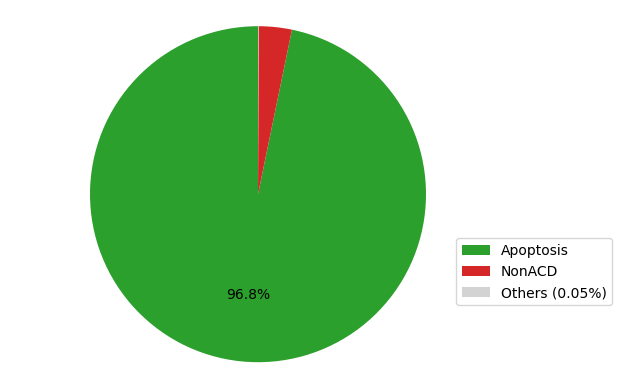

In [20]:
sim_final = sim_next.copy()
sim_final.update_parameters(max_time=dur_tnf)
sim_final.network.set_istate(nodes, new_istates)
sim_final_fig = sim_final.copy()
sim_final_fig.network.set_output(outputs)
res_final_fig = sim_final_fig.run()
res_final_fig.plot_piechart()

In [21]:
res_final = sim_final.run()
res_final.get_nodes_probtraj()["TNF"].iloc[-1]

0.9999999999999999

# Fourth, no TNF

In [22]:
new_istates = change_input(to_istates(res_final.get_states_probtraj(), nodes), "TNF", 0)

Warning, node FASL was previously bound to othernodes


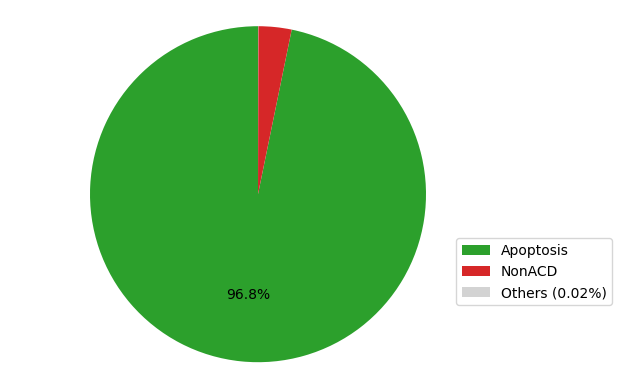

In [23]:
sim_final2 = sim_final.copy()
sim_final2.update_parameters(max_time=dur_no_tnf)
sim_final2.network.set_istate(nodes, new_istates)
sim_final2_fig = sim_final2.copy()
sim_final2_fig.network.set_output(outputs)
res_final2_fig = sim_final2_fig.run()
res_final2_fig.plot_piechart()

In [24]:
res_final2 = sim_final2.run()
res_final2.get_nodes_probtraj()["TNF"].iloc[-1]

0.0

# Fifth, with TNF

In [25]:
new_istates = change_input(to_istates(res_final2.get_states_probtraj(), nodes), "TNF", 1)

Warning, node FASL was previously bound to othernodes


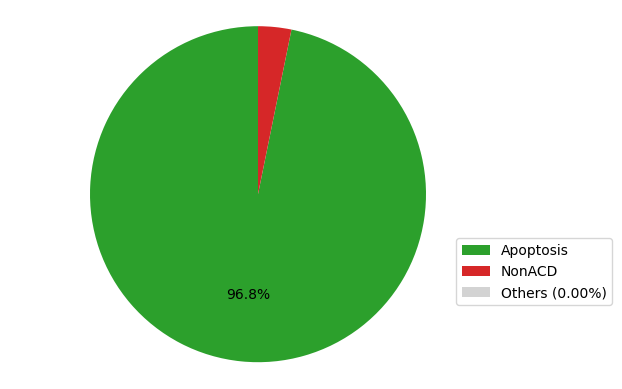

In [26]:
sim_final3 = sim_final2.copy()
sim_final3.update_parameters(max_time=dur_tnf)
sim_final3.network.set_istate(nodes, new_istates)
sim_final3_fig = sim_final3.copy()
sim_final3_fig.network.set_output(outputs)
res_final3_fig = sim_final3_fig.run()
res_final3_fig.plot_piechart()

In [27]:
res_final3 = sim_final3.run()
res_final3.get_nodes_probtraj()["TNF"].iloc[-1]

1.0

# Finally, we merge the trajectories of the five simulations

In [28]:
table = res_short_fig.get_states_probtraj()
table_next = res_next_fig.get_states_probtraj()
table_final = res_final_fig.get_states_probtraj()
table_final2 = res_final2_fig.get_states_probtraj()
table_final3 = res_final3_fig.get_states_probtraj()

We need to fix the index since all the five simulations start at 0

In [29]:
table_next.index = np.array([value + dur_tnf - 1 for value in table_next.index.values])
table_final.index = np.array([value + dur_tnf + dur_no_tnf - 2 for value in table_final.index.values])
table_final2.index = np.array([value + dur_tnf + dur_no_tnf + dur_tnf - 3  for value in table_final2.index.values])
table_final3.index = np.array([value + dur_tnf + dur_no_tnf + dur_tnf + dur_no_tnf - 4 for value in table_final3.index.values])

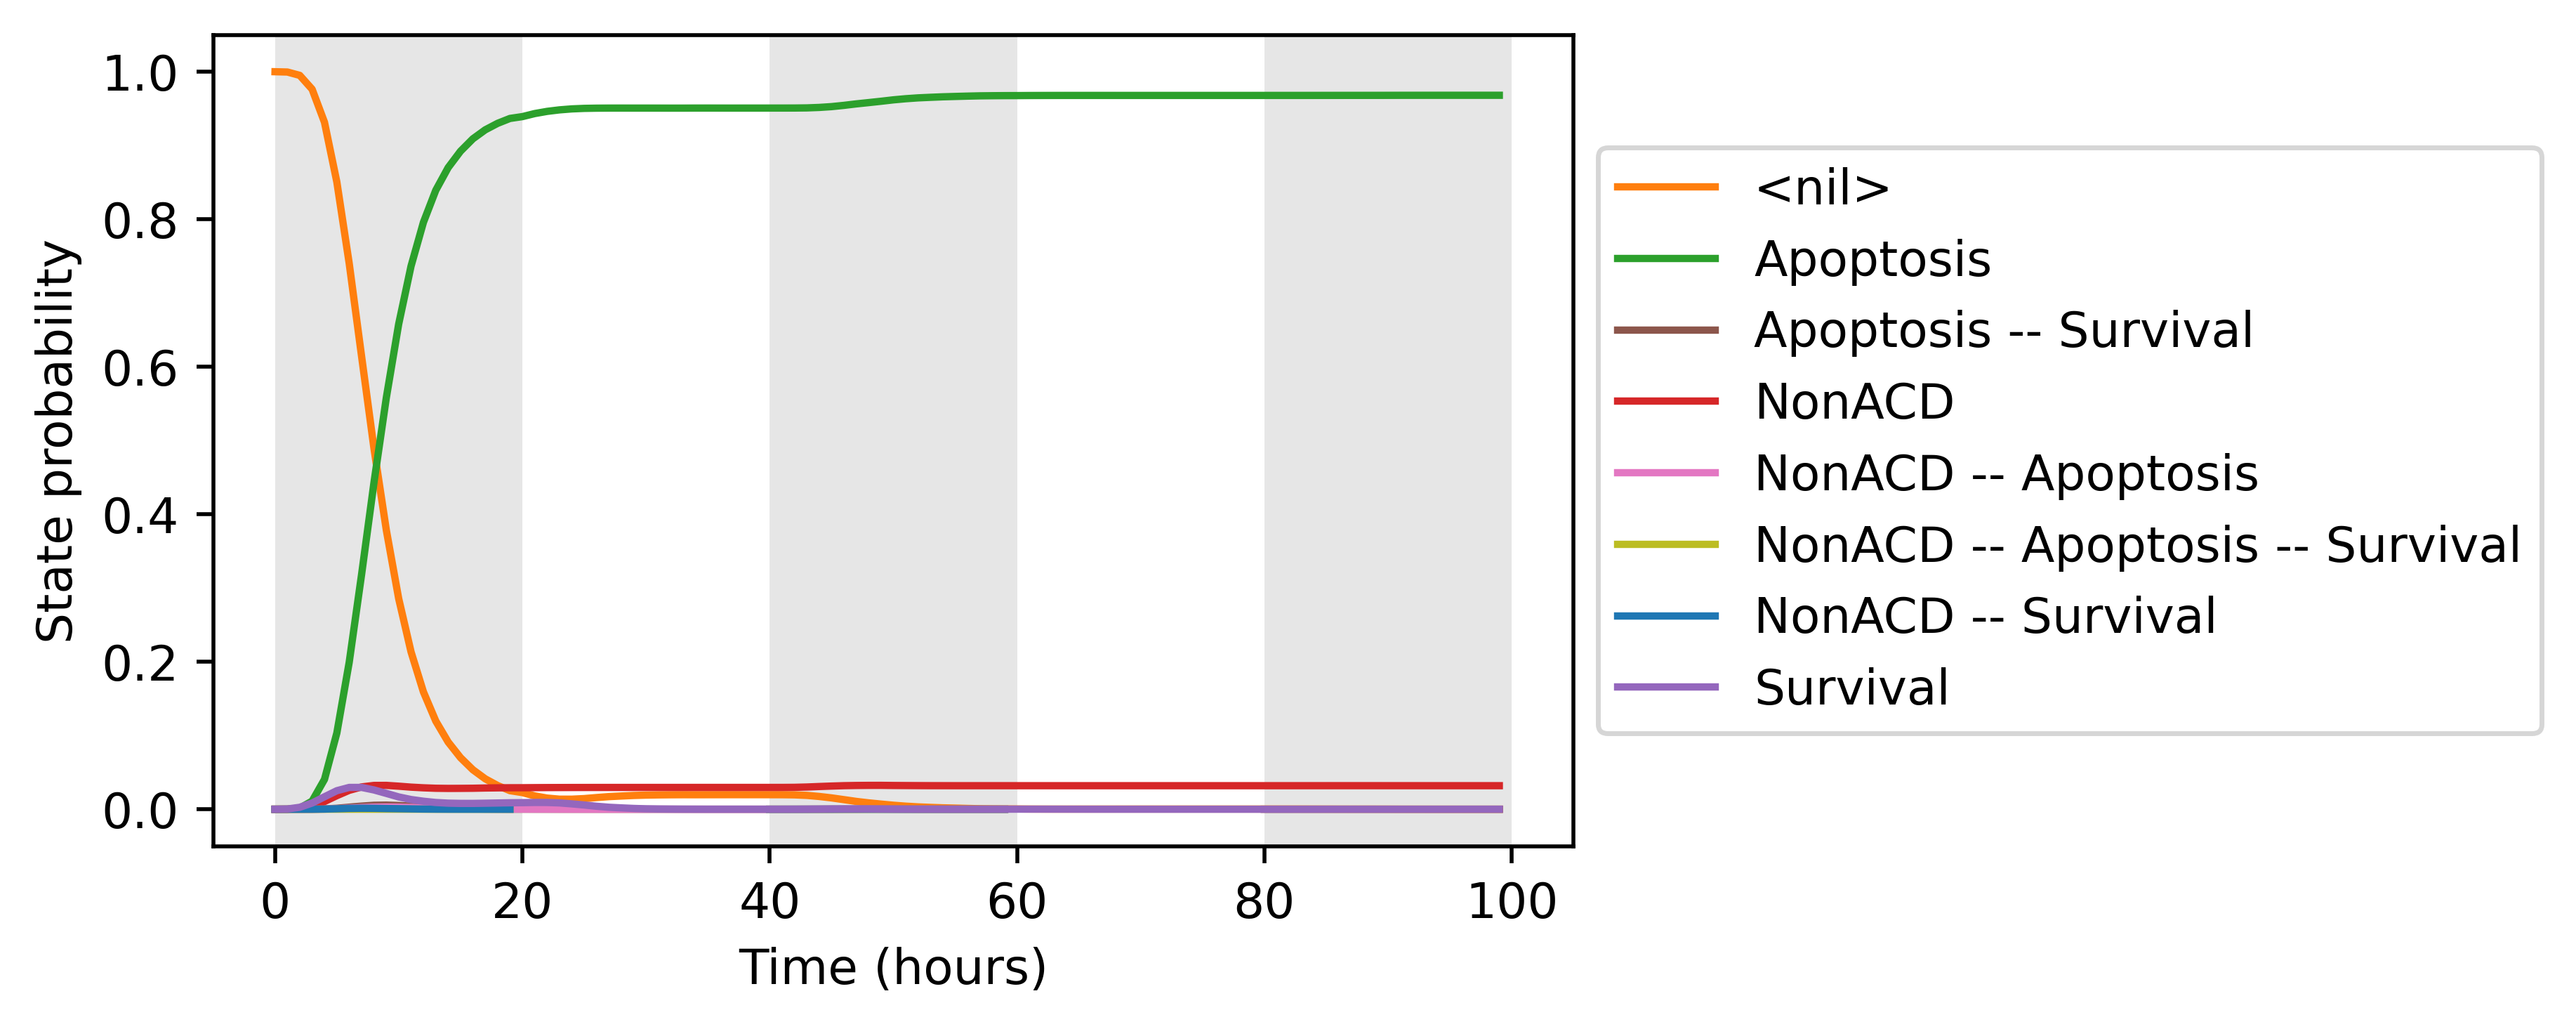

In [30]:
fig = plt.figure(figsize=(5,3), dpi=500)
fig.subplots(1)
pd.concat([table, table_next, table_final, table_final2, table_final3]).plot(ax=fig.axes[0],color=palette)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Time (hours)')
plt.ylabel('State probability')
fig.axes[0].axvspan(0., dur_tnf-1, facecolor='0.9')
fig.axes[0].axvspan(dur_tnf+dur_no_tnf-2, dur_tnf+dur_no_tnf+dur_tnf-3, facecolor='0.9')
fig.axes[0].axvspan(dur_tnf+dur_no_tnf+dur_tnf+dur_no_tnf-4, dur_tnf+dur_no_tnf+dur_tnf+dur_no_tnf+dur_tnf-5, facecolor='0.9')